# Домашнее задание по ML №1

Результат выполнения задания — это отчёт в формате html на основе Jupyter Notebook. Нормальный отчёт должен включать в себя:

* Краткую постановку задачи и формулировку задания
* Описание минимума необходимой теории и/или описание используемых инструментов - не стоит переписывать лекции или Википедию
* Подробный пошаговый рассказ о проделанной работе
* Аккуратно оформленные результаты
* Внятные выводы – не стоит относится к домашнему заданию как к последовательности сугубо технических шагов, а стоит относится скорее как к небольшому практическому исследованию, у которого есть своя цель и свое назначение.

In [17]:
# coding: utf-8
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

%matplotlib inline

ImportError: No module named 'nltk'

## Часть 1. Предварительная обработка текстов

Проведите предобработку новостей: токенизацию, приведение к нижнему регистру, лемматизацию. Проверьте, есть ли в коллекции дубликаты. Посчитайте, сколько новостей относится к каждому резонансному событию.

In [14]:
df_events = pd.read_csv('events.csv')
df_news = pd.read_csv('raw_news.csv', index_col='id')

In [15]:
print(df_news.groupby('event_id').describe())

          text                                                               
         count unique                                                top freq
event_id                                                                     
1          100    100   Эхо России (ehorussia.com), Москва, 13 января...    1
2           51     51   Известия (iz.ru), Москва, 20 января 2017 ДОНА...    1
3           84     84   ГосНовости (rusgosnews.com), Москва, 20 февра...    1
4           62     62   NewsRu.com, Москва, 2 марта 2017 ФБК ПОТРЕБОВ...    1
5            2      2   CNN: ВЛАДИМИР ПУТИН - САМЫЙ МОГУЩЕСТВЕННЫЙ ЧЕ...    1
6           41     41   News2 (news2.ru), Москва, 20 марта 2017 УМЕР ...    1
7          100    100   НТВ (ntv.ru), Москва, 23 марта 2017 БРИТАНСКИ...    1
8           27     27   The Russian Times (therussiantimes.com), Моск...    1
9           82     76   Коммерсантъ. Новости информ. центра, Москва, ...    2
10         100    100   RTVi (rtvi.com), Москва, 27 марта 2017 С

Дубликаты в девятом резонансном событии.

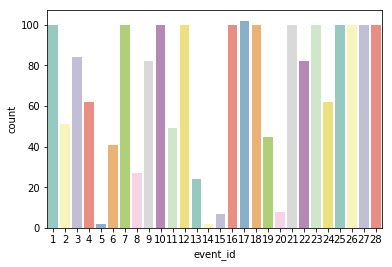

In [16]:
sns.countplot(x=df_news['event_id'], data=df_news, palette="Set3")

In [ ]:
Из представленного выше графика видно, что данные неоднородны.